In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
SM_FRAMEWORK=tf.keras
from tensorflow import keras 
import segmentation_models as sm
from tensorflow.keras import optimizers
from tensorflow.python.keras.optimizers import TFOptimizer
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

C:\Users\markz\Miniconda3\envs\newey\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\markz\Miniconda3\envs\newey\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\markz\Miniconda3\envs\newey\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\markz\Miniconda3\envs\newey\lib\site-packages\tensorflow\pyth

Segmentation Models: using `tf.keras` framework.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))



In [3]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [4]:
#optional
SIZE_X = 512
SIZE_Y = 512

In [5]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\markz\OneDrive\Desktop\EY Datascience


In [6]:
train_images = []

for directory_path in glob.glob("alternative_data\source"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

train_images = np.array(train_images)


(2301, 512, 512, 3)
2301


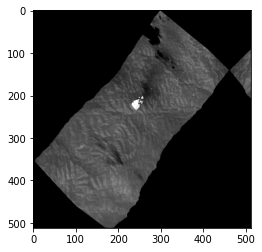

In [7]:
plt.imshow(train_images[200], cmap='gray')
print(train_images.shape)
print(len(train_images))

In [8]:
train_masks = []


for directory_path in glob.glob("alternative_data/mask/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        norm_image = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        train_masks.append(norm_image)

train_masks = np.array(train_masks)


0.0
(2301, 512, 512)
2301


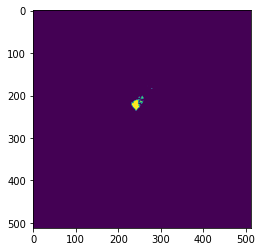

In [9]:
plt.imshow(train_masks[200])
print(train_masks[200][350][150])
print(train_masks.shape)
print(len(train_masks))

In [10]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [12]:
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


#print(x_train.shape)

(1840, 512, 512, 3)
(461, 512, 512, 3)
(1840, 512, 512, 1)
(461, 512, 512, 1)


In [20]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', layers=tf.keras.layers, models=tf.keras.models, backend=tf.keras.backend)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [21]:


history=model.fit(x_train, y_train,
                     batch_size=5,
                     epochs=25,
                     verbose=1,
                     validation_data=(x_val, y_val))
print('done')

Train on 1840 samples, validate on 461 samples
Epoch 1/25
1840/1840 [==============================] - 117s 64ms/sample - loss: 0.2018 - mean_squared_error: 0.0556 - val_loss: 0.4330 - val_mean_squared_error: 0.0480
Epoch 2/25
1840/1840 [==============================] - 112s 61ms/sample - loss: 0.1439 - mean_squared_error: 0.0411 - val_loss: 0.4188 - val_mean_squared_error: 0.1271
Epoch 3/25
1840/1840 [==============================] - 113s 61ms/sample - loss: 0.1244 - mean_squared_error: 0.0358 - val_loss: 0.6288 - val_mean_squared_error: 0.2303
Epoch 4/25
1840/1840 [==============================] - 112s 61ms/sample - loss: 0.1117 - mean_squared_error: 0.0322 - val_loss: 0.1638 - val_mean_squared_error: 0.0510
Epoch 5/25
1840/1840 [==============================] - 112s 61ms/sample - loss: 0.0978 - mean_squared_error: 0.0283 - val_loss: 0.3036 - val_mean_squared_error: 0.0884
Epoch 6/25
1840/1840 [==============================] - 113s 61ms/sample - loss: 0.0852 - mean_squared_error

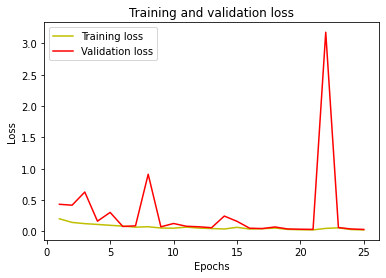

In [22]:
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

tf.keras.models.save_model(model, 'training images_normal7.h5' )

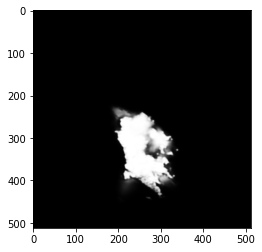

In [23]:
from tensorflow import keras
model = keras.models.load_model('training images_normal7.h5', compile=False)
#Test on a different image
#READ EXTERNAL IMAGE...
names = ["JORDAN_235_P1_201901281204_MGA94_55", "JORDAN_294_P1_201902011150_MGA94_55", "MACALISTER91_648_P1_201903070444_MGA94_55", "WALHALLA_313_P1_201902020733_MGA94_55", "WALHALLA_353_P1_201902031625_MGA94_55"]

for name in names:
    test_img = cv2.imread("real_test_images7/source/" + name + '.png', cv2.IMREAD_COLOR)       
    test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
    test_img = np.expand_dims(test_img, axis=0)

    prediction = model.predict(test_img)
    prediction_image = prediction.reshape(mask.shape)
    plt.imshow(prediction_image, cmap='gray')
    plt.imsave('real_test_images7/mask/' + name + '.png', prediction_image, cmap='gray')
